In [21]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow.keras.models import load_model
from tensorflow_examples.lite.model_maker.core.export_format import ExportFormat
from tensorflow_examples.lite.model_maker.core.task import image_preprocessing

from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker.image_classifier import ModelSpec

In [22]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# The path where you have downloaded the PlantDoc Dataset
train_dir = 'PlantDoc-Dataset/train'
test_dir = 'PlantDoc-Dataset/test'

# Load the images from the directory
train_data = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32)
test_data = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32)

# Get the class names
class_names = train_data.class_names

Found 2342 files belonging to 28 classes.
Found 236 files belonging to 27 classes.


In [23]:
# Construct the list of labels and loads the training and validation datasets

label_names = ds_info.features['label'].names

train_data = ImageClassifierDataLoader(ds_train,
                                       ds_train.cardinality(),
                                       label_names)
validation_data = ImageClassifierDataLoader(ds_validation,
                                            ds_validation.cardinality(),
                                            label_names)

# This selects the name of the model to use (mobilenet v3)

model_name = 'mobilenet_v3_large_100_224' 

# this maps specific model name to the URLs for their crresponding pre-trained weights to the tensorflow hub 
map_model_name = {
    'cropnet_cassava':
        'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1',
    'cropnet_concat':
        'https://tfhub.dev/google/cropnet/feature_vector/concat/1',
    'cropnet_imagenet':
        'https://tfhub.dev/google/cropnet/feature_vector/imagenet/1',
    'mobilenet_v3_large_100_224':
        'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
}

model_handle = map_model_name[model_name]

image_model_spec = ModelSpec(uri=model_handle)

In [24]:
# Constants
MODEL_WEIGHTS_FILE = 'trained_model_weights.h5'

# Check if the model weights file exists
if not os.path.exists(MODEL_WEIGHTS_FILE):
    # Build the model by training the model with the training dataset
    model = image_classifier.create(
        train_data,
        model_spec=image_model_spec,
        batch_size=128,
        learning_rate=0.03,
        epochs=5,
        shuffle=True,
        train_whole_model=True,
        validation_data=validation_data)

    # Save the trained model's weights
    model.model.save_weights(MODEL_WEIGHTS_FILE)
else:
    # Create a new model with the same architecture
    new_model = image_classifier.create(
        train_data,
        model_spec=image_model_spec,
        batch_size=128,
        learning_rate=0.03,
        epochs=0,  # Set epochs to 0 to avoid training
        shuffle=True,
        train_whole_model=True,
        validation_data=validation_data)
    
    # Load the saved model's weights
    new_model.model.load_weights(MODEL_WEIGHTS_FILE)
    model = new_model

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_2 (Hub  (None, 1280)             4226432   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,232,837
Trainable params: 4,208,437
Non-trainable params: 24,400
_________________________________________________________________
None


In [25]:
# This is a mapping dictionary of the disease codes to names

name_map = dict(
    cmd='Mosaic Disease',
    cbb='Bacterial Blight',
    cgm='Green Mite',
    cbsd='Brown Streak Disease',
    healthy='Healthy',
    unknown='Unknown')

[(name_map[x],x) for x in label_names]

[('Bacterial Blight', 'cbb'),
 ('Brown Streak Disease', 'cbsd'),
 ('Green Mite', 'cgm'),
 ('Mosaic Disease', 'cmd'),
 ('Healthy', 'healthy')]

In [26]:
# Use the trained model to make predictions off the standard test dataset split from cassava 

# test_data = ImageClassifierDataLoader(ds_test, ds_test.cardinality(),
#                                       label_names)
# model.predict_top_k(test_data)

In [27]:
import boto3
import io
import numpy as np
import tensorflow as tf

s3 = boto3.resource('s3', region_name='us-west-2')
bucket = s3.Bucket('planttest1234')

images = {}
summaries = bucket.objects.all()
for f in summaries:
    bstream = io.BytesIO()
    if str(f.key).upper().endswith(".JPG") or str(f.key).upper().endswith(".JPEG"):
        bucket.Object(f.key).download_fileobj(bstream)
        image = tf.image.decode_jpeg(bstream.getvalue(), channels=3)
        
        # Check if the image is the correct size
        if image.shape[0] != 224 or image.shape[1] != 224:
            # Resize the image to be 224x224
            image = tf.image.resize(image, [224, 224])
        
        images[f.key] = image.numpy()
        print(f.key)

image_1.JPG
image_2.JPG


In [28]:
# Construct a new dataset using my image files 
v = [x for x in images.values() if x.shape[0] == 224 and x.shape[1] == 224 and x.shape[2] == 3]

# Convert the list of images to a numpy array and normalize it to 0-1 range
input_1 = np.stack(v, axis=0)  # Stack images along a new dimension to form a 4D tensor
input_1 = input_1 / 255.0  # Normalize to 0-1 range

# Get top-k predictions
predicted_prob = model.model.predict(input_1)

# Get the top-k predictions
topk_prob, topk_id = tf.math.top_k(predicted_prob, k=1)

# Map the label ids back to labels
topk_label = np.array(label_names)[topk_id.numpy()]

index_name_map = {i: name_map[name] for i, name in enumerate(label_names)}

# Convert tensors to numpy arrays before using them as dictionary keys
labels = [(index_name_map[x[0]], x[1]) for x in zip(topk_id.numpy().flatten(), topk_prob.numpy().flatten())]

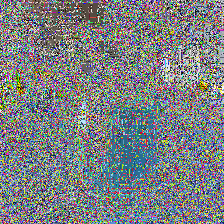

('Brown Streak Disease', 0.3392071)


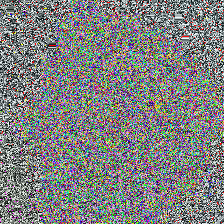

('Bacterial Blight', 0.50133353)


In [29]:
# Show the images 
from PIL import Image as im

i=0
for d in v:
    display(im.fromarray((d * 255).astype(np.uint8)))  # Convert normalized image back to 0-255 range
    print(labels[i])
    i+=1


In [30]:
dynamodb = boto3.resource('dynamodb', region_name='us-west-2')
table_name = 'Garden'
table = dynamodb.Table(table_name)
email_client = boto3.client("ses", region_name="us-west-2")

# Get the labels for the test data using the trained model
labels = [(name_map[x[0][0]]) for x in model.predict_top_k(test_data2)]
garden_id = 0
# Store the labels in the DynamoDB table
diseased = True
for label in labels:
    # Create an item to be inserted into the table
    if (label == "Healthy"):
        diseased = False
    key = "item" + str(i)
    i += 1
    
    item = {
        "Garden_Id": garden_id,
        "label": label,
        "diseased": diseased
#         "probability": 
    }
        
    # Insert the item into the table
    table.put_item(TableName="Garden", Item=item)
    garden_id += 0
    
    body_data = str(garden_id) + " - " + label + " detected"
    body_page = """
        <html>
        <head></head>
        <body>
        <h2>Disease Detected - """ + label + """</h2>""" + """
        <p>Found in GardenId = """ + str(garden_id) + """
        </body>
        </html> """
    if diseased:
        try:
            email_client.send_email(Source="ttsega03@gmail.com", 
                                   Destination={
                                       "ToAddresses": [
                                           "mesteddy14@gmail.com"
                                       ]
                                   }, Message={
                                       "Subject": {
                                           "Data": "Disease Detected",
                                           "Charset": "UTF-8"
                                       },
                                       "Body": {
                                           "Text": {
                                               "Data": body_data,
                                               "Charset": "UTF-8"
                                           },
                                           "Html": {
                                               "Data": body_page,
                                               "Charset": "UTF-8"
                                           }
                                       }
                                   }
                                   )
        except Exception as e:
            print(e)
    garden_id += 1
    print("done!")

NameError: name 'test_data2' is not defined